In [1]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, FK5
from astropy.coordinates import AltAz
import numpy as np
import matplotlib.pyplot as plt

f = open("simulatedSources_wSub_halfNoise.ascii", "r")
f.readline()
f.readline()
f.readline()
f.readline()
f.readline()
f.readline()

Ra1=[]
Dec1=[]
sourceId=[]
Resid_Isl_rms=[]
Flux_1=[]


for line in f:
    if 'nan'in line:
        continue
    if 'C' in line:
        continue
    if 'M' in line:
        continue
    flux = line.strip().split()[8]
    residual = line.strip().split()[42]
    div = float(flux)/float(residual)
    if div <=6:
        continue
    idx = line.strip().split()[1]
    sourceId.append(int(idx))
    ra = line.strip().split()[2]
    dec =line.strip().split()[4]
    mycoord = SkyCoord(ra, dec, frame=coord.FK5, unit=(u.deg,u.deg))
    Ra1.append(mycoord.ra.deg)
    Dec1.append(mycoord.dec.deg)

    
Ra_ACE=[]
Dec_ACE=[]
RA_ACE=[]
DEC_ACE=[]
myf=open("ACE_source.txt")
myf.readline()
myf.readline()
myf.readline()


for line in myf:
    ra = line.strip().split()[2].replace(":"," ").replace(",", " ")
    dec = line.strip().split()[3].replace(".", " ", 2).replace(",", " ")
    mycoord = coord.SkyCoord(ra, dec, frame=coord.FK4, unit=(u.hourangle,u.deg))
    RA_ACE.append(mycoord.ra.deg)
    DEC_ACE.append(mycoord.dec.deg)
    
for i in sourceId:
    Ra_ACE.append(RA_ACE[i])
    Dec_ACE.append(DEC_ACE[i])


coord_ACE = SkyCoord(Ra_ACE, Dec_ACE, frame=coord.FK5, unit=(u.deg,u.deg))
extracted = SkyCoord(Ra1, Dec1, frame=coord.FK5, unit=(u.deg,u.deg))   

In [2]:
dist = coord_ACE.separation(extracted)
dist2 = extracted.separation(extracted[:,np.newaxis]).arcmin
idx=np.diag_indices(dist2.shape[0])
dist2[idx[0],idx[1]]=1e5
dist2=np.min(dist2,axis=0)


select_ACE=coord_ACE[np.logical_and(dist.arcmin<15 ,  dist2>15)]
select_extr=extracted[np.logical_and(dist.arcmin<15 ,  dist2>15)]

In [3]:
ACE = EarthLocation(lat=52.91*u.deg, lon=6.87*u.deg, height=1*u.m)
utcoffset = 0*u.hour  # UT
time = Time('2018-11-07 19:55:08.75') - utcoffset

AA = AltAz(location=ACE, obstime=time)

c_extracted = SkyCoord(np.array(select_extr.ra.deg), np.array(select_extr.dec.deg), unit='deg')
coord_aa_extracted = c_extracted.transform_to(AA)

c_ace = SkyCoord(np.array(select_ACE.ra.deg), np.array(select_ACE.dec.deg), unit='deg')
coord_aa_ace = c_ace.transform_to(AA)

#alt is longitude
#az is latitude

ace_cartesian = SkyCoord(np.array(coord_aa_ace.az.radian), np.array(coord_aa_ace.alt.radian), unit='radian')
ace_cartesian.representation = 'cartesian'

ext_cartesian = SkyCoord(np.array(coord_aa_extracted.az.radian), np.array(coord_aa_extracted.alt.radian), unit='radian')
ext_cartesian.representation = 'cartesian'

Diff_X=[]
Diff_Y=[]
Diff_Z=[]

for i, j in zip(ace_cartesian, ext_cartesian):
    diff_x = i.x - j.x
    diff_y = i.y - j.y
    diff_z = i.z - j.z
    Diff_X.append(diff_x)
    Diff_Y.append(diff_y)
    Diff_Z.append(diff_z)



<IPython.core.display.Javascript object>


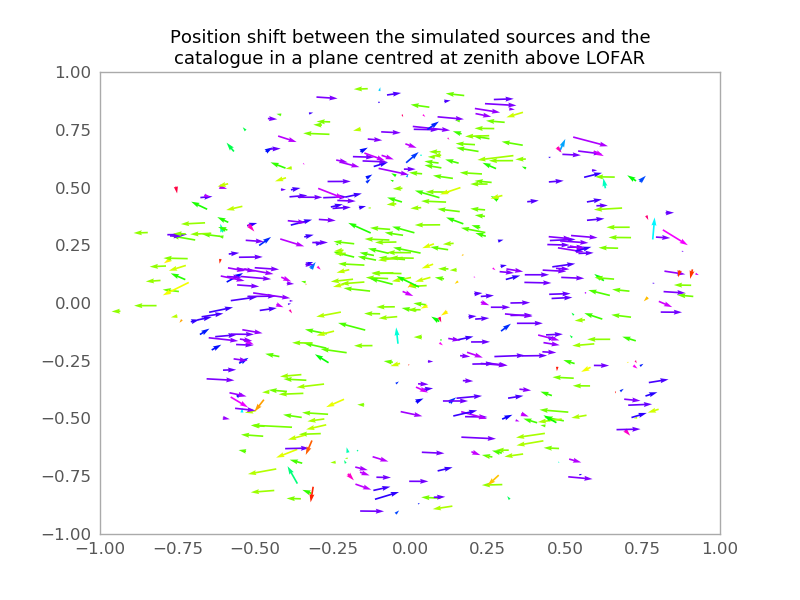

In [4]:
%matplotlib notebook
from matplotlib.colors import Normalize
from textwrap import wrap
fig, ax = plt.subplots()

ax.quiver(ace_cartesian.x, ace_cartesian.y, Diff_X, Diff_Y, np.arctan2(Diff_X,Diff_Y),cmap='hsv',norm=Normalize(-np.pi,np.pi))
ax.axis([-1,1,-1,1])
title = ax.set_title("\n".join(wrap('Position shift between the simulated sources and the catalogue in a plane centred at zenith above LOFAR', 60)), fontdict={'fontsize': 13, 'fontweight': 'medium'})
title.set_y(1.0)
plt.grid(False)
plt.show()
plt.savefig('position_shift_simulation.png', dpi=600)